# <u>**Contents**</u>

### 1. Introduction
### 2. Image Pre-processing
### 3. Training on Three Impressive Combinaions of Algorithms with Annotaiton
 #### 3.1. **Classification using Eigenface + Nearest Centre Classifier** 
 #### 3.2. **Classification using Deep Learning (Convolutional Neural Network)** 
 #### 3.3. **Classification using FaceNet Model + K Nearest Neighbor Classifier** 
### Appendix
 ####    -      Reference
 
 
 
 -----------------------

# **1. Introduction**
Nowadays, face recognition is able to achieve high state of the art accuracy through Deep Learning algorithms such as Convolutional Neural Networks or Vision Transformers (Dosovitskiy et al., 2021) .However, Deep Learning methods usually requires a large amount of dataset, numbering in the hundred thousands to millions to prevent overfitting (Seguin, 2017). Since we do not have access to this large amount of dataset, a better way is to use a simpler Machine Learning classification model such as Nearest Centre Classifier. Since the models are simpler and not suitable to handle complex dataset such as face images, we can use the Eigenface approach (Turk & Pentland, 1991). We first apply Principal Component Analysis (PCA) to lower the dimensions of the faces. Once the lower dimension eigenfaces are generated from the PCA method, we use these as training data for the Nearest Centre Classifier. This will require less computational power and can be done in a shorter time (Lee, 2022). The tradeoff of this method is reduction in accuracy due to the information loss when compressing.

All the neccessary files can be found in [G0191 Project](https://xmueducn-my.sharepoint.com/:f:/g/personal/cst2004268_xmu_edu_my/Eq5BTCpmEvJFjrzxjOpO7-MBAPpcX53eXab1CjQgOgnI8g).

When running the code in our ```G0191_Assignment_Project.ipnyb``` file, the directory of the file should be followed as shown below:

```
├── G0191_Assignment_Project.ipynb
├── sample_data
│   ├── face_images.zip
└── sample_model
│   ├── facenet_keras.h5
```

The package libraries necessary are:
```
cv2 
numpy
matplotlib
sklearn
tensorflow
keras
```




The code below is to extract the face images with ```.pgm``` format from our ``` face_images.zip ``` file using the zipfile library. The images extracted are then reshaped into sizes of 100 by 100.

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import zipfile
from time import time
from sklearn import preprocessing
# Faces are stored in folders of zip file
# Respecive folders are named with members name
# Read face image from zip file 
shape=(100, 100)
faces = {}
# obtaining the images from zip file
# zip file is used because smaller size and more convenient to upload
with zipfile.ZipFile("sample_data/face_images.zip") as zips:
    for filename in zips.namelist():
        if not filename.endswith(".pgm"):
            continue # not a face picture
        with zips.open(filename) as image:
            strang = filename.split('face_images/')[1]
            # If we extracted files from zip, we can use cv2.imread(filename) instead
            # convert all images into np arrays
            read_image = cv2.imdecode(np.frombuffer(image.read(), np.uint8), cv2.IMREAD_GRAYSCALE)
            resized_image = cv2.resize(read_image, (shape[0], shape[1]))
            faces[strang] = np.array(resized_image)

faceshape = list(faces.values())[0].shape

A function to plot images are implemented as shown below. This will help in displaying the face images obtained from the members and is also useful for debugging purposes. In the example given, 2 rows of 10 images each are shown.


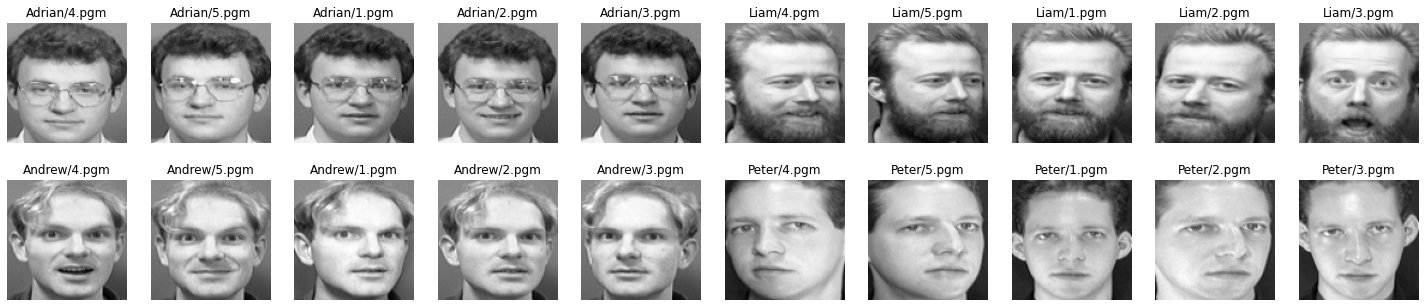

In [ ]:
def plot_images(images, title, height, width, rows, columns):
    plt.figure(figsize=(2 * columns, 2 * rows))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=1.0, hspace=.20)

    for i in range(rows * columns):
        plt.subplot(rows, columns, i + 1)
        plt.imshow(images[i].reshape((height, width)), cmap=plt.cm.gray)
        plt.title(title[i])
        plt.axis('off')

faceimages = list(faces.values())[:] 
facetitles = list(faces.keys())[:]
# plotting sample images 
plot_images(faceimages, facetitles, 100, 100, 2, 10)


# 2. Image Pre-processing

A simple function to sharpen the images are also implemented. The image is sharpened by a filter with a kernel. The filtering is carried out by convolution of a 2D matrix with our image. In this case, the matrix is 3x3 sharpening kernel. The reason for this is because the filter is most useful for highlighting edges and lines in an image. As shown in the sample image before and after applying the sharpening preprocessing, it can be seen that the curves and edges of the face has been highlighted (LearnOpenCV, 2021).

Text(0.5, 1.0, 'Sharpened')

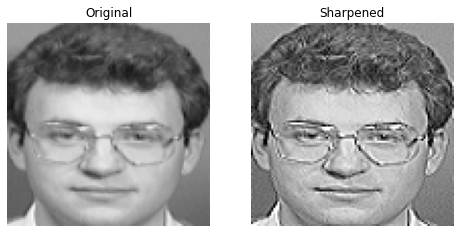

In [ ]:
# preprocessing and sharpening image 
def sharpen_images(image, ddepth = -1):
    kernel = np.array([[0, -1, 0],
                   [-1, 5,-1],
                   [0, -1, 0]])
    sharpened = cv2.filter2D(src=image, ddepth=ddepth, kernel=kernel)
    return sharpened

sharpened_images = []

for i in range(len(faceimages)):
  sharpened_images.append(sharpen_images(faceimages[i]))
# comparing sharpened and unsharpened image
fig, axes = plt.subplots(1,2,sharex=True,sharey=True,figsize=(8,6))
axes[0].imshow(faceimages[0], cmap="gray")
axes[0].set_axis_off()
axes[0].set_title("Original")

axes[1].set_axis_off()
axes[1].imshow(sharpened_images[0], cmap="gray")
axes[1].set_title("Sharpened")

Our face images are obtained from individual group members and also from the internet. There are 46 people in our training data, where 6 are from the pictures collected by the members while 40 more are found from the internet. Each person have 5 greyscale(pgm) face images with different orientation totalling up to 230 images. The number of test images are 15, which mainly consists of the images obtained from the members. The face images are separated into training dataset and testing dataset. The face images contained in each folder are added into our $X_{facetrain}$ array dataset, with the name of the folder acting as its label and consequently added into the $Y_{facetrain}$ array. The face images contained in test is added into the $X_{facetest}$ array, with the name of each image added into the $Y_{facetest}$ array acting as its label. 

In [ ]:
X_facetrain = []
Y_facetrain = []
X_facetest = []
Y_facetest = []
facematrix = []
facelabel=[]

for key, val in faces.items():
    # preprocess the image
    if key.startswith("test"):
        X_facetest.append(val.flatten())
        folder_name = key.split('/')[1].rsplit('.')[0].rsplit('_')[0]
        Y_facetest.append(folder_name)
        continue

    X_facetrain.append(sharpen_images(val).flatten())
    Y_facetrain.append(key.split('/')[0])
    facematrix.append(val)
    facelabel.append(key.split("/")[0])

print(f'Number of train images: {len(X_facetrain)}')
print(f'Number of test images: {len(X_facetest)}')

Number of train images: 230
Number of test images: 15


#3.  Training on Three Impressive Combination of Algorithms

# **1. Classification using Eigenface + Nearest Centre Classifier**
Below is the implementation of the Principal Component Analysis (PCA) class from scratch. The outline of the algorithms is as follows (Shanthamallu & Santhias, 2021):
1. Mean normalize the given data $X$ such that the new data $X_c$ has a mean of 0.

2. Compute the covariance matrix of mean normalized data 
\begin{align}
\Sigma = \frac{1}{n} X_c^T X_c 
\end{align}

3. Compute the eigenvectors and the eigenvalues of the covariance matrix by carrying out Eigenvalue decomposition 
\begin{align}
\Sigma= VUV^T 
\end{align}

4. Project the given data points onto the frst p Eigenvectors by multiplying the first p Eigenvectors (also known as projection vectors) by the mean normalized data 
\begin{align}
X_r = X_c \cdot V[:n\_components]
\end{align}
where $V$ represents the matrix whose $i_{th}$ column is the eigenvector is eigenvalue in $U$, and $U$ represents a matrix with eigenvalues along its diagonal.

5. Obtain the eigenfaces by dotting the centered data with the mean normalized projection matrix.
\begin{align}
X_{eigenfaces} = X_c^T \cdot X_r
\end{align}

However, the computation of eigenvalues and eigenvectors from the Covariance matrix at step 3 requires a long time to run. This is due to the large dimensions of the Covariance matrix (10000 x 10000). When using a 12GB RAM, the time taken to compute the eigenvalues and eigenvectors could take up to 15 to 20 minutes. 

Another way to obtain the eigenvectors and eigenvalues is by performing Singular Value Decomposition (Wall et al., 2003).

3. (alternative) Use Singular Decomposition on the centered data to get the root eigenvalue and eigenvectors.
\begin{align}
X_c = U\Sigma V^T
\end{align}
where $U$ represents the matrix whose $i_{th}$ column is the eigenvector is eigenvalue in $\Sigma^2$, and $V$ represents a matrix with eigenvalues along its diagonal

Hence, we have added in a choice to use SVD to compute the eigenvectors and eigenvalues by setting the initialization variable svd_compute = True in the PCA class. Computation carried out by the SVD method in a 12GB RAM system only requires 20 to 30 seconds.

In [ ]:
class PCA():
    """
    Implementation of PCA based on Lecture Notes Chapter 1 
    First standardize the data by subtracting the mean of the matrix
    Then, find the covariance matrix based on the equation given in slides
    Obtain the eigenvalues and eigenvectors from the covariance matrix
    WARNING: This will take a lot of time because of the large 
    matrix multiplication (10000 x 10000).
    After obtaining the eigenvalues and eigenvectors, sort it 
    and select n_components of the first eigenvectors known as
    projected components. The eigenfaces are obtained by dotting the
    projected components with the standardized image.
    """

    def __init__(self, n_components=None, svd_compute=False,random_state=None, standardize=True):
        self.n_components = n_components
        self.svd_compute = svd_compute
        self.random_state = random_state
        self.standardize = standardize

    def standardize_data(self, images):
        # flatten images first
        self.straightened_image = np.resize(images, (self.num_images, shape[0] * shape[1]))
        # find the mean of the flattened image
        self.average_vector = np.sum(self.straightened_image, axis = 0, dtype='float64') / self.num_images 
        # make the flattened vector into matrix of shape image
        self.average_matrix = np.tile(self.average_vector, (self.num_images, 1))
        # print(self.average_matrix)
        # print(self.average_matrix.shape)
        # subtract the mean from the image
        self.centered_image = self.straightened_image - self.average_matrix 

        return self.centered_image

    def get_covariance_matrix(self, ddof=0):
        # calculate covariance matrix with standardized matrix A
        C = np.dot(self.centered_image.T, self.centered_image) / (self.num_images)
        # print(f'The shape of covariance is {C.shape}')
        return C

    def _svd_solver(self, X):
        U, S, V = np.linalg.svd(X.T, compute_uv=True)
        S = np.square(S)
        # S represents the eigenvalues, U represents the eigenvectors
        return S, U

    def get_eigenvectors(self, C):
        # calculate eigenvalues & eigenvectors of covariance matrix 'C'
        if (self.svd_compute == True):
          self.eigenvalues, self.eigenvectors = self._svd_solver(self.centered_image)
        else:
          self.eigenvalues, self.eigenvectors = np.linalg.eig(C)
        
        # pair the eigenvalues and eigenvectors to be used 
        # get_cumulative_variance function
        self.eigen_pair = [(self.eigenvalues[index], self.eigenvectors[:,index]) for index in range(len(self.eigenvalues))]

        # sort eigenvalues descending and select columns based on n_components
        n_cols = np.argsort(self.eigenvalues)[::-1][:self.n_components]

        selected_vectors = self.eigenvectors[:, n_cols]
        return selected_vectors
    
    def get_cumulative_variance(self):
      self.eigen_pair.sort(reverse=True)

      sorted_eigenvalues  = [self.eigen_pair[index][0] for index in range(len(self.eigenvalues))]

      self.explained_variance_ratio = np.real(np.cumsum(sorted_eigenvalues)/sum(sorted_eigenvalues))

      # x-axis for number of principal components kept
      num_comp = range(1,len(sorted_eigenvalues)+1)

      plt.figure(figsize=(20, 20))

      plt.title('Variance Explained Ratio against Number of Principal Components')

      plt.xlabel('Principal Components')

      plt.ylabel('Cumulative Variance Explained Ratio')

      plt.xticks(np.arange(0, faceshape[0] * faceshape[1], 250.0))

      plt.scatter(num_comp, self.explained_variance_ratio)

      plt.show()

    def project_matrix(self, eigenvectors):
        P = np.dot(self.centered_image, eigenvectors)
        return P
    
    def normalized(self, x, axis=-1, order=2):
      distance = np.linalg.norm(x, order, axis)
      # all 0 distances are set to minimum of 1's
      distance[distance==0] = 1
      return x / np.expand_dims(distance, axis)


    def fit(self, images):
        self.images_copy = images.copy()
        self.num_images = len(images)
        # straighten the image first into M(shape[0]) x N(shape[1]) column vector
        self.centered_image = self.standardize_data(images)
        # obtaining the covariance matrix 
        self.cov_mat = self.get_covariance_matrix()
        
        self.eigenvectors = self.get_eigenvectors(self.cov_mat)

        self.projected_components = self.project_matrix(self.eigenvectors)

        self.projected_components = self.normalized(self.projected_components)
        
        # the computation generates complex values hmm 
        self.projected_components = np.real(self.projected_components)
        
        # project the given data points by multiplying 
        # the projection vectors with the centered images
        self.eigvec_C = np.dot(self.centered_image.T, self.projected_components)
        
        self.eigenfaces = self.normalized(self.eigvec_C.T)
        
        return self.eigenfaces

    def transform(self, X):
      # get the weights necessary to transform the test images
      # the test images are transformed using the mean values obtained
      # the training images
      self.weights = np.dot(self.eigenfaces, (self.images_copy - self.average_vector).T)
      
      self.normalized_matrix = np.tile(pca.average_vector, (len(X), 1))
      
      X_transformed = np.dot(self.eigenfaces, (X - self.normalized_matrix).T)

      return X_transformed


    def plot_mean_image(self):
        plt.imshow(np.resize(self.average_vector, (shape[0], shape[1])), cmap='gray')
        plt.title('Mean Image')
        plt.show()

    # plots a number of eigenfaces for visualization
    def plot_eigenvectors(self):
        labels = [i for i in range(10)]
        plot_images(self.eigenfaces, labels, 100, 100, 2, 5)


The PCA algorithm is fitted with the training data. The number of components set as 300. This means that out of the 10000 dimensions in each image, only the top 300 components that contains the greatest information will be preserved. 


In [ ]:
facematrix = np.array(facematrix)
X_facetrain = np.array(X_facetrain)

pca_slow = PCA(n_components=300)
t0 = time()
X_train_pca_slow = pca_slow.fit(X_facetrain)
time_without = time() - t0
print(f'Time elapsed for PCA compression without SVD: %0.3fs' % (time_without))

pca = PCA(n_components=300, svd_compute=True)
t0 = time()
X_train_pca = pca.fit(X_facetrain)
time_with = time() - t0
print(f'Time elapsed for PCA compression with SVD: %0.3fs' % (time_with))

Time elapsed for PCA compression without SVD: 669.589s
Time elapsed for PCA compression with SVD: 22.078s


When fitting the PCA with the training data, a comparison between the computing the eigenvectors and eigenvalues from the covariance matrix and computing the eigenvectors and eigenvalues from SVD of the normalized image is shown. The PCA method computed with SVD is 30~35 times faster than without SVD.

Text(0.5, 0, 'Method Used')

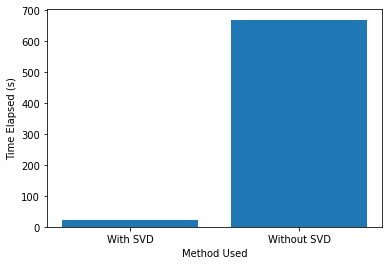

In [ ]:
plt.bar(['With SVD', 'Without SVD'], [time_with, time_without])
plt.ylabel("Time Elapsed (s)")
plt.xlabel("Method Used")

A graph of the variance explained ratio against the number of principal components is also displayed. The Variance Explained Ratio describes the number of principal components that represents the information contained. From the cumulative graph shown, the number of components needed to achieve an Explained Variance Ratio of 95% is shown below the graph.

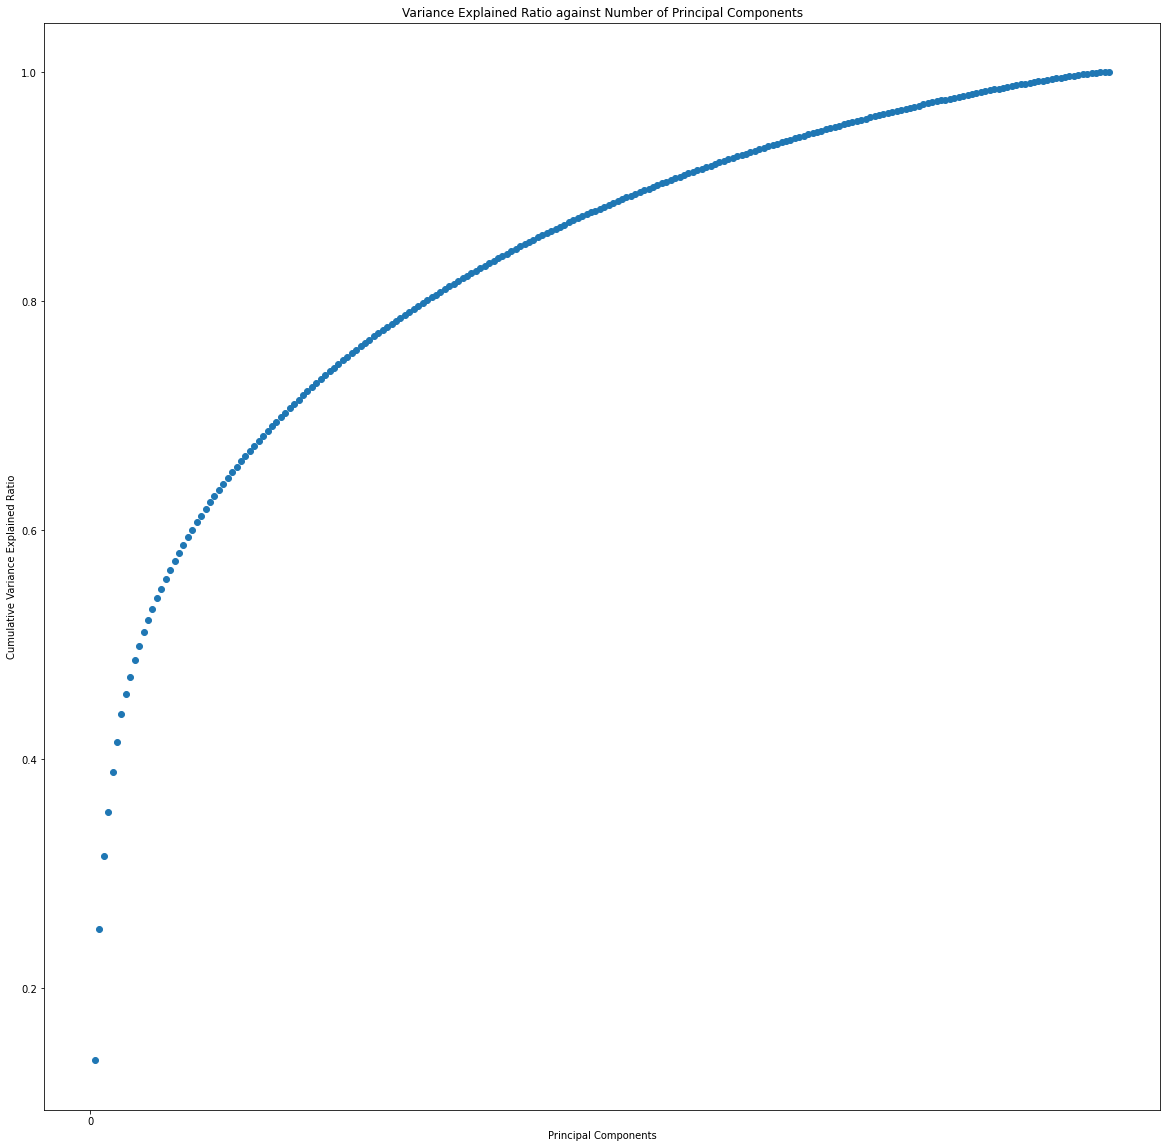

Number of principal components needed to achieve 95% variance: 166


In [ ]:
pca.get_cumulative_variance()
print(f'Number of principal components needed to achieve 95% variance: {sum(pca.explained_variance_ratio < 0.95)}')

Mean eigenface


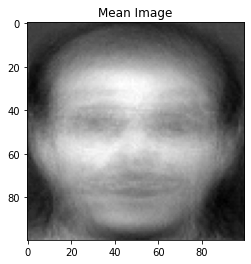

In [ ]:
print('Mean eigenface')
pca.plot_mean_image()

Generated top 10 eigenvectors:


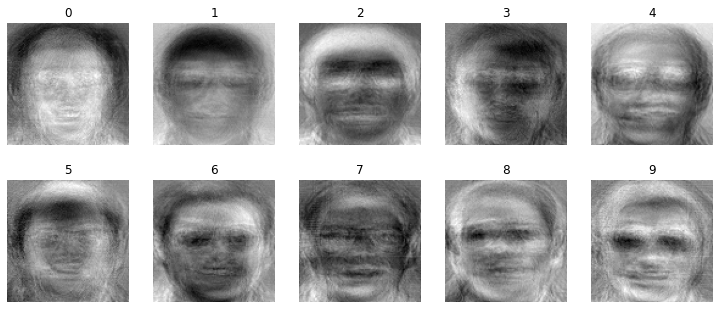

In [ ]:
print('Generated top 10 eigenvectors:')
pca.plot_eigenvectors()

Once the eigenfaces have been obtained, new test images can classified using Nearest Centre Classifier / Minimum Distance Classifier. The outline of the classifier is as follows (Wang, 2022):

1. For each object class $𝜔_𝑘$, we find the centroid $𝑚_𝑘$ of the set of samples $𝑥^𝑘_1, 𝑥^𝑘_2, … , 𝑥^𝑘_𝑁$ belonging to class $𝜔_𝑘$.
2. For any object feature vector, $x$, find the distances of $x$ to each of the class centroids (or prototypes).
3. Then we classify an unknown object, $x$, as belonging to the class whose centroid ($m_k$) is closest (i.e. having minimum distance) to the unknown object’s feature vector.

In our case, no clustering of centroid is carried out due to to the low number of images in each class. The test images are reshaped in to a feature vector of $n$ x 1, where $n$ represents the number of pixels in the image. Then, the classifier measures the Euclidean Distance of the transformed test images with the weights of the trained eigenfaces, and classifies according to the lowest Euclidean Distance. If the Euclidean Distance is larger than 6000, then the following image is labelled as an 'unknown' image.

Nearest match Andrea with Euclidean distance 3750.686
Predicted: Andrea
Expected: Andrea


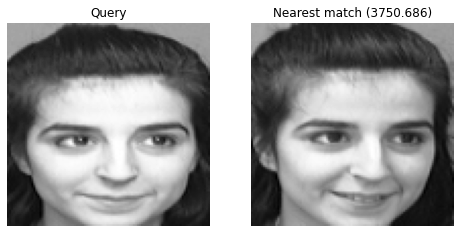

Nearest match Oliver with Euclidean distance 3585.930
Predicted: Oliver
Expected: Oliver


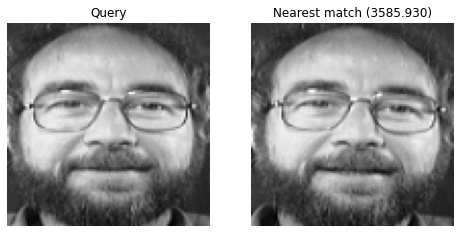

Nearest match Junwei with Euclidean distance 4069.362
Predicted: Junwei
Expected: Junwei


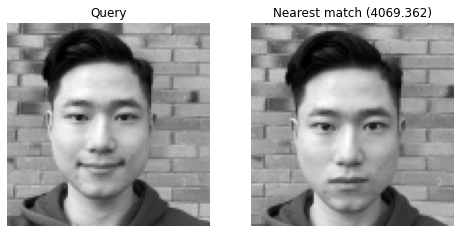

Nearest match Junwei with Euclidean distance 4462.222
Predicted: Junwei
Expected: Junwei


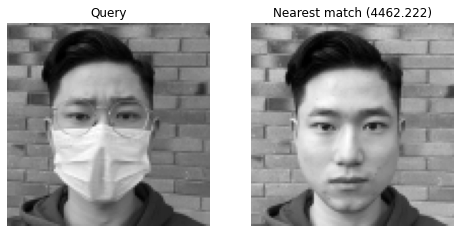

Nearest match Peter with Euclidean distance 4243.123
Predicted: Peter
Expected: Peter


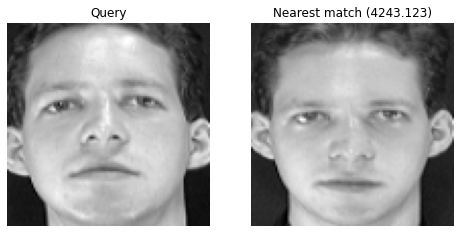

Nearest match Kechen with Euclidean distance 4537.706
Predicted: Kechen
Expected: Kechen


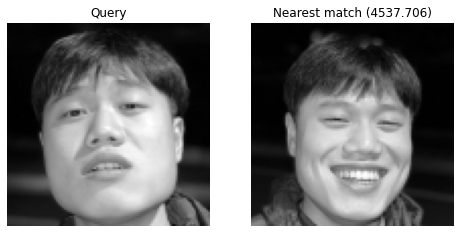

Nearest match Unknown with Euclidean distance 6189.936108
Predicted: Unknown
Expected: Chenhong


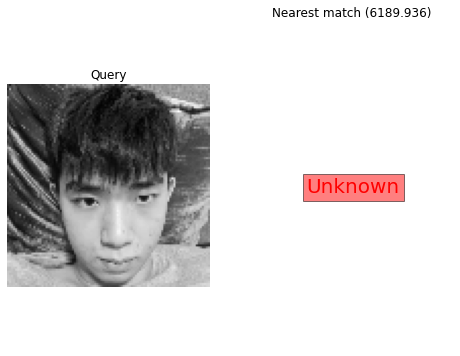

Nearest match Ramli with Euclidean distance 3829.522
Predicted: Ramli
Expected: Ramli


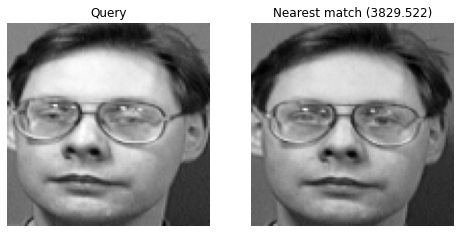

Nearest match Unknown with Euclidean distance 7011.643432
Predicted: Unknown
Expected: Chenhong


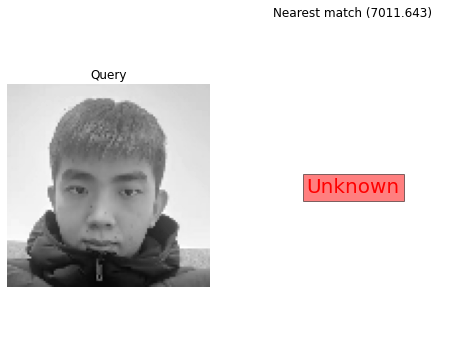

Nearest match Yichang with Euclidean distance 4513.612
Predicted: Yichang
Expected: Yichang


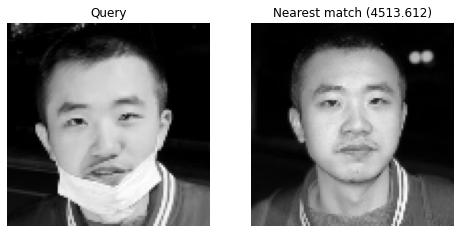

Nearest match Adrian with Euclidean distance 2692.577
Predicted: Adrian
Expected: Adrian


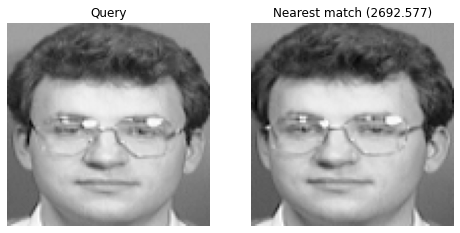

Nearest match Yichang with Euclidean distance 4392.797
Predicted: Yichang
Expected: Yichang


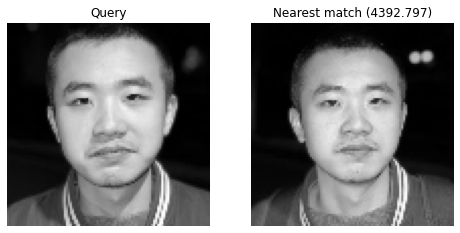

Nearest match Hanting with Euclidean distance 4666.763
Predicted: Hanting
Expected: Hanting


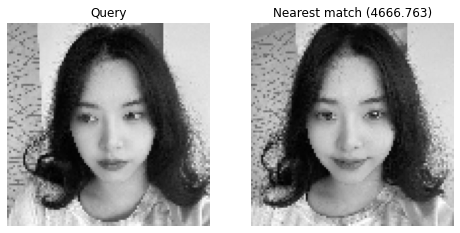

Nearest match Hanting with Euclidean distance 4431.414
Predicted: Hanting
Expected: Hanting


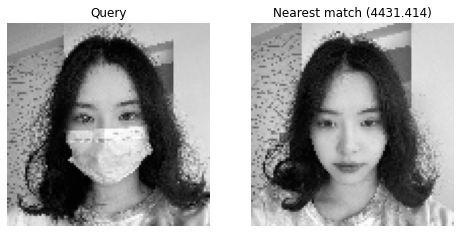

Nearest match Maxus with Euclidean distance 3905.705
Predicted: Maxus
Expected: Maxus


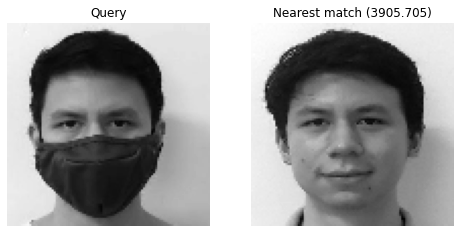

In [ ]:
# Transform the X_facetest data with PCA(based on X_facetrain)
X_facetest_pca = pca.transform(X_facetest)
correct = 0
for i in range(len(X_facetest)):
    euclid_distance = np.linalg.norm(pca.weights - X_facetest_pca.T[i].reshape(-1, 1), axis = 0)
    nearest_match = np.argmin(euclid_distance)
    fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(8,6))
    axes[0].set_axis_off()
    axes[0].imshow(X_facetest[i].reshape(faceshape), cmap="gray")
    axes[0].set_title("Query")

    if (euclid_distance[nearest_match] < 6000):
      print("Nearest match %s with Euclidean distance %.3f" % (facelabel[nearest_match], euclid_distance[nearest_match]))
      print(f'Predicted: {facelabel[nearest_match]}')
      print(f'Expected: {Y_facetest[i]}')
      if (facelabel[nearest_match] == Y_facetest[i]):
        correct = correct + 1
      axes[1].set_axis_off()
      axes[1].imshow(facematrix[nearest_match].reshape(faceshape), cmap="gray")
      title = 'Nearest match (%.3f)' % (euclid_distance[nearest_match])
      axes[1].set_title(title)
    # if the euclidean distance is more than 6000, then classifiy as unknown
    else:
      print("Nearest match Unknown with Euclidean distance %.3f" %  euclid_distance[nearest_match])
      print(f'Predicted: Unknown')
      print(f'Expected: {Y_facetest[i]}')
      axes[1].set_title("Nearest match")
      axes[1].set_axis_off()
      title = 'Nearest match (%.3f)' % (euclid_distance[nearest_match])
      axes[1].set_title(title)
      axes[1].text( s='Unknown',
        horizontalalignment='center',
        verticalalignment='center',
        fontsize=20, color='red',
        x=50, y=50,
        bbox=dict(facecolor='red', alpha=0.5)
        )
    plt.show()

In [ ]:
print(f'Test accuracy: {(correct / len(X_facetest)) * 100:.2f}%')

Test accuracy: 86.67%


From the results shown above, it can be seen that our PCA + NCC classifier works well for 13 out of 15 test images with a test accuracy of 86.67%. It is able to cope with in-plane rotation (Kechen), and also deal with images involving face masks (Maxus, Hanting & Junwei). However, it is unable to identify Chenhong's face images due to the large difference in lighting and in-plane rotations. Hence, the images are labelled as "unknown" by our classifier for exceeding Eucliden Distance of 6000.

# **2. Classification using Deep Learning (Convolutional Neural Network)**
Now that we have the seen the performance of our simple PCA + NCC approach, we will look at Deep Learning on the face datasets as a comparison. The Deep Learning algorithm used will be a Convolutional Neural Network, a neural network widely used for image recognition and image classification problems (Valueva et al., 2020). 

In [ ]:
from numpy import load, expand_dims
import tensorflow as tf
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
from keras.models import Sequential
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder 
from keras.models import load_model
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD

def resize_picture_RGB(filename, required_size = (160, 160)):
  read_image = cv2.imdecode(np.frombuffer(filename.read(), np.uint8), cv2.IMREAD_COLOR)
  resized_image = cv2.resize(read_image, required_size)
  face_array = np.array(resized_image)
  return face_array

def resize_picture(filename, required_size = (160, 160)):
  read_image = cv2.imdecode(np.frombuffer(filename.read(), np.uint8), cv2.IMREAD_GRAYSCALE)
  resized_image = cv2.resize(read_image, required_size)
  face_array = np.array(resized_image)
  return face_array

X_train = []
y_train = []
X_test = []
y_test = []

def data_load(path, color=False):
	with zipfile.ZipFile(path) as zips:
		for filename in zips.namelist():		
			if not filename.endswith('.pgm'):
				continue
			if not filename.startswith('face_images/test'):
				with zips.open(filename) as image:
					if (color == True):
						X_train.append(resize_picture_RGB(image))
					else:
						X_train.append(resize_picture(image))
					strang = filename.split('face_images/')[1]
					folder_name = strang.rsplit('/')[0]
					y_train.append(folder_name)
			if filename.startswith('face_images/test'):
				with zips.open(filename) as image:
					strang = filename.split('face_images/')[1]
					folder_test_name = strang.split('/')[1].rsplit('.')[0].rsplit('_')[0]
					y_test.append(folder_test_name)
					if (color == True):
						X_test.append(resize_picture_RGB(image))
					else:
						X_test.append(resize_picture(image))

data_load('sample_data/face_images.zip', color=True)


The data are first preprocessed first to be fitted into the  Convolutional Neural Network. The summary of the model is also shown.

In [ ]:
# data_load('sample_data/archive_neural.zip', color=True)
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
  
X_train = X_train.reshape(X_train.shape[0], 160, 160, 3)
X_test = X_test.reshape(X_test.shape[0], 160, 160, 3)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_test /= 255

n_classes = 46

out_encoder = LabelEncoder()
out_encoder.fit(y_train)
y_train = out_encoder.transform(y_train)
y_test = out_encoder.transform(y_test)


model = Sequential()

model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1), input_shape=(160,160,3), activation='relu'))

# basic layer of convolutional neural network using uniform distribution
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPool2D((2, 2)))

model.add(Flatten())
 
model.add(Dense(160, activation='relu'))
model.add(Dense(n_classes))

# compiling the sequential model
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'],
              optimizer='adam',
              )

model.summary()

Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_278 (Conv2D)         (None, 156, 156, 32)      2432      
                                                                 
 conv2d_279 (Conv2D)         (None, 156, 156, 32)      9248      
                                                                 
 max_pooling2d_138 (MaxPooli  (None, 78, 78, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_280 (Conv2D)         (None, 78, 78, 32)        9248      
                                                                 
 conv2d_281 (Conv2D)         (None, 78, 78, 32)        9248      
                                                                 
 max_pooling2d_139 (MaxPooli  (None, 39, 39, 32)       0         
 ng2D)                                               

As shown in the model summary, the Convolutional Neural Network used is a simple one with small number of parameters. This is to prevent overfitting due to the low number of images in our training dataset. Overfitting is when the large capacity of the neural network 'copies' the training data which results in it doing badly on unseen data and not generalize well. When fitting the model, the model is first trained on our training data and is evaluated on the test data set for validation. 

In [ ]:
opt = SGD(learning_rate=0.001, momentum=0.9)
t0 = time()
result = model.fit(X_train, y_train, batch_size=128, epochs=12,
                   validation_data=(X_test, y_test),
                   )
end = time()
print(f"Time taken for training: %.2fs" %(end - t0))

Epoch 1/12
2/2 [==============================] - 26s 11s/step - loss: 3.9830 - accuracy: 0.0217 - val_loss: 3.7063 - val_accuracy: 0.1333
Epoch 2/12
2/2 [==============================] - 23s 11s/step - loss: 3.7944 - accuracy: 0.0739 - val_loss: 3.6872 - val_accuracy: 0.0667
Epoch 3/12
2/2 [==============================] - 24s 11s/step - loss: 3.7682 - accuracy: 0.0957 - val_loss: 3.5338 - val_accuracy: 0.1333
Epoch 4/12
2/2 [==============================] - 24s 11s/step - loss: 3.7000 - accuracy: 0.0957 - val_loss: 3.1597 - val_accuracy: 0.3333
Epoch 5/12
2/2 [==============================] - 24s 11s/step - loss: 3.5498 - accuracy: 0.1261 - val_loss: 2.6727 - val_accuracy: 0.4667
Epoch 6/12
2/2 [==============================] - 24s 11s/step - loss: 3.2174 - accuracy: 0.2304 - val_loss: 2.0781 - val_accuracy: 0.6000
Epoch 7/12
2/2 [==============================] - 24s 11s/step - loss: 2.6589 - accuracy: 0.3870 - val_loss: 1.7201 - val_accuracy: 0.7333
Epoch 8/12
2/2 [===========

The performance of the simple Convolutional Neural Network works quite well, with a 89.57% training accuracy and 86.67% validation accuracy which is the test accuracy. The test accuracy obtained is the same as the PCA + NCC approach, with 12 out of 15 images classified correctly. Throughout the entire training, the validation accuracy is mostly higher than the training accuracy. This usually happens when the testing dataset is small. A graph of training loss against validation loss and training accuracy against validation accuracy is shown below. 

Graph of Train Loss


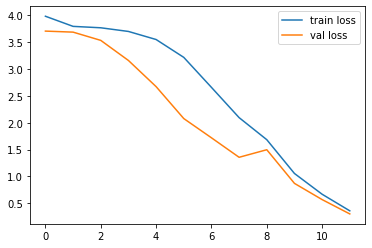

Graph of Train Accuracy


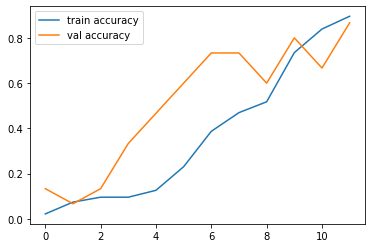

In [ ]:
print('Graph of Train Loss')
plt.plot(result.history['loss'], label='train loss')
plt.plot(result.history['val_loss'], label='val loss')
plt.legend()
plt.show()

print('Graph of Train Accuracy')
plt.plot(result.history['accuracy'], label='train accuracy')
plt.plot(result.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.show()

Predicted: Andrea
Expected: Andrea


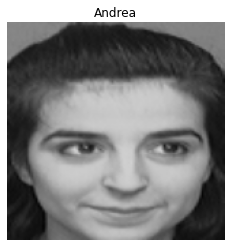

Predicted: Oliver
Expected: Oliver


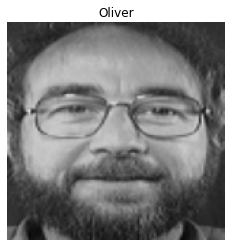

Predicted: Junwei
Expected: Junwei


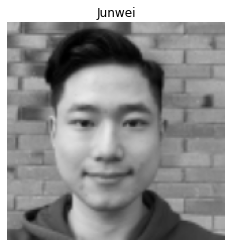

Predicted: Junwei
Expected: Junwei


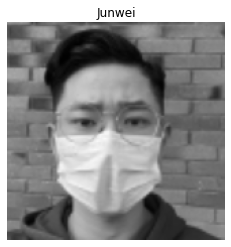

Predicted: Peter
Expected: Peter


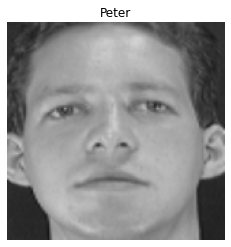

Predicted: Kechen
Expected: Kechen


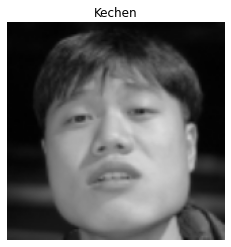

Predicted: Kechen
Expected: Chenhong


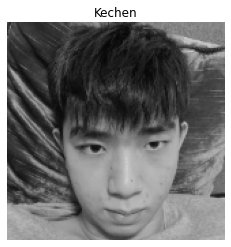

Predicted: Chris
Expected: Ramli


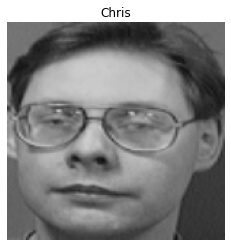

Predicted: Chenhong
Expected: Chenhong


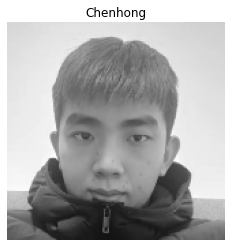

Predicted: Yichang
Expected: Yichang


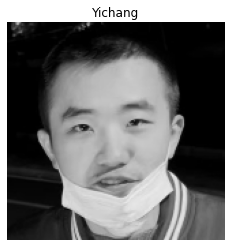

Predicted: Adrian
Expected: Adrian


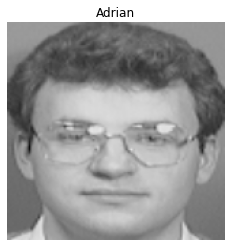

Predicted: Yichang
Expected: Yichang


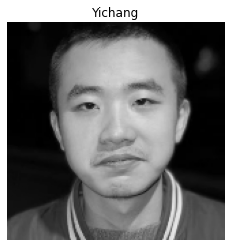

Predicted: Hanting
Expected: Hanting


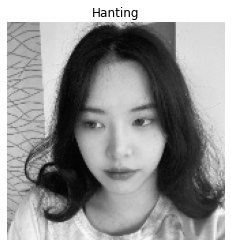

Predicted: Hanting
Expected: Hanting


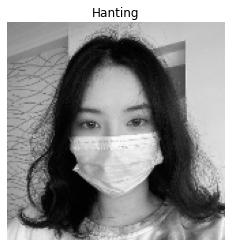

Predicted: Maxus
Expected: Maxus


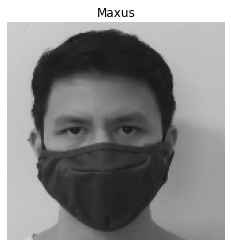

In [ ]:
for i in range(X_test.shape[0]):
  face_pixels = X_test[i]
  # expanding the dimension of the face image into a tensor 
  img_array = np.expand_dims(face_pixels, 0)
  # the trained model is used for prediction 
  y_hat = model.predict(img_array)
  # takes the largest probability
  score = tf.nn.softmax(y_hat[0])
  # reconvert the numerical values into respective names 
  predict_names = out_encoder.inverse_transform([np.argmax(score)])[0]
  face_class = y_test[i]
  face_name = out_encoder.inverse_transform([face_class])
  print('Predicted: %s' % (predict_names))
  print(f'Expected: {face_name[0]}')
  plt.imshow(face_pixels)
  plt.axis('off')
  title = f'{predict_names}'
  plt.title(title)
  plt.show()


# **3. Classification using FaceNet Model + K Nearest Neighbor Classifier**
As shown in the results obtained above, the performance of our Convolutional Neural Network model is the same as our Eigenface + NCC approach. However, the training accuracy gets stuck at 89.57%. This is due to the low amount of training data which makes it difficult for Deep Learning algorithms to work well (Najafabadi et al., 2015). Instead, a better approach for deep learning on small image datasets is
to use a pretrained model. In our situation, a pretrained model is a model that was previously trained on a large face image dataset for image-classification purposes. If this original model is trained on a general and large enough dataset, it can maintain the spatial hierarchy of features learned and act as a generic model for recognizing all types of faces. Hence, its features can prove useful for many different computer vision problems that involves faces, even though these new problems may involve completely different faces than those
of the original task. In this case, we will be using FaceNet, a ResNet-Inception Deep Learning model trained on 1 million celebrity face images. The pretrained FaceNet model is provided by Hiroki Tanai at [Keras FaceNet PreTrained Model (92.3 MB)](https://drive.google.com/drive/folders/1pwQ3H4aJ8a6yyJHZkTwtjcL4wYWQb7bn) in the **model** directory or in [our files](https://xmueducn-my.sharepoint.com/:f:/g/personal/cst2004268_xmu_edu_my/Eq5BTCpmEvJFjrzxjOpO7-MBAPpcX53eXab1CjQgOgnI8g) in the **sample_model** directory. Even though FaceNet is initially trained on colored images, it should work well with our grayscale images due to the facial features already learned in the model.

In [ ]:
X_train = []
y_train = []
X_test = []
y_test = []
data_load('sample_data/face_images.zip', color=True)
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

As shown in the model summary below, the FaceNet model layers is enormous compared to our Convolutional Neural Network. The large size of the model makes it difficult to retrain our face images due to the large magnitude computational power and time needed. Hence, a more suitable method is to transform the face images into face embedding vectors using FaceNet (Forsythe, 2021). The outline of our approach is as follows (Le, 2019):

1. Import the pretrained Inception model FaceNet, which helps to transform the face images into embedding vectors.
2. Extract the embeddings vectors of the training face matrix using the pre-trained FaceNet. Encode the train and test labels into numerical values and fit the embedding vectors along with the encoded names into a K Nearest Neighbor classifier.
3. Transform the test data into embedding vectors, and use the trained K Nearest Neighbor to find the nearest embedding vectors from the test data.

In [ ]:
model = load_model('sample_model/facenet_keras.h5')
print('FaceNet Loaded')
# model is extremely huge
#model.summary()

FaceNet Loaded


Face embedding vectors are features extracted from face images with all the important information necessary to recognize a face. This makes FaceNet an excellent choice based on the reasons explained in e). A face embedding is similar to an eigenface, with the difference that it is much better at extracting essential facial features due to the large amount of training data it has been trained on. These face embeddings can then be fitted into classifiers as training data (Le, 2019). The classifier that will be used is the K Nearest Neighbour classifier from our course. To summarise, the FaceNet model will only be used to transform the training and test data into face embeddings, which will then be fitted and tested by the KNN classifier. No retraining of the neural network is needed.

In [ ]:
# converting the images so that it can be predicted
# by the models 11
# FaceNet requires requires standardized images of color,
# with each of them having dimensions of (1, 160, 160, 3) 
def transform_embedding(model, pixels):
	# scale pixel values
	pixels = pixels.astype('float32')
	# standardize pixel values across channels (global)
	# mean, std = face_pixels.mean(), face_pixels.std()
	pixels = (pixels - pixels.mean()) / pixels.std()
	# add dimension to transform array into
	# batch of a single sample, shape is (1, 160, 160, 3)
	# this can then be fed into FaceNet model
	samples = expand_dims(pixels, axis=0)
	# return the prediction of the model
	yhat = model.predict(samples)
	return yhat[0]

Transform the face images in $X_{train}$ and $X_{test}$ into face embedding vectors:

In [ ]:
X_train_transformed = []
for faces in X_train:
	embedding = transform_embedding(model, faces)
	X_train_transformed.append(embedding)
X_train_transformed = np.array(X_train_transformed)
print(f'Shape of X_train_transformed: {X_train_transformed.shape}')
# convert each face in the test set to an embedding
X_test_transformed = []
for faces in X_test:
	embedding = transform_embedding(model, faces)
	X_test_transformed.append(embedding)
X_test_transformed = np.array(X_test_transformed)
print(f'Shape of X_test_transformed: {X_test_transformed.shape}')

(230, 128)
(15, 128)


The class below is an implementation of the K Nearest Neighbor classifier from our course. The classifier takes in the number of neighbors, k and returns the predicted class along with its probability of certainty. The outline of the classifier is as follows (Wang, 2022):

1. Given a measurement 𝑥, find the 𝑘 nearest samples to 𝑥. 

2. From these 𝑘 samples, check how many of them belong to each
class. 

3. The measurement 𝑥 will be assigned to the class with the most samples in
the 𝑘 nearest samples.


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer

class KNearestNeighbor:
    def __init__(self, k=3):
        self.k = k
    
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
    
    def predict(self, X_test):
        # get predictions for every row in test data
        y_pred = []
        y_prob = []
        for x in X_test: 
          prediction, probability = self.get_pred(x)
          y_pred.append(prediction)
          y_prob.append(probability)
        return (np.array(y_pred), np.array(y_prob))

    def get_pred(self, x_test):
        # get distances of test_row vs all training rows
        distances = []
        for x in self.X_train:
          distances.append(self.euclidean_distance(x_test, x))
        
        # get indices of the nearest k-neighbors
        indices = np.argsort(distances)[:self.k]
        
        # get corresponding y-labels of training data
        k_labels = [self.y_train[idx] for idx in indices]

        k_labels = np.array(k_labels)

        max_label = np.argmax(np.bincount(k_labels))

        prob = (np.count_nonzero(k_labels == max_label)) / len(k_labels)
        
        # return most common label
        return (max_label, prob)

    def euclidean_distance(self, x1, x2):
        # calculate euclidean distance for a row pair
        squared_distance = np.sum((x1 - x2)**2)
        return np.sqrt(squared_distance)  

Below is the fitting of the train and test images. The train and test image matrix are first normalized using the Normalizer from Scikit-Learn's library. The labels which represent the names of faces are encoded into numerical values, then it is fitted along with the train face images into our K Nearest Neighbor Classifier. The KNN classifier is then used to carry out predictions on the test face images and the predicted labels are compared with the expected labels.


In [ ]:
knn = KNearestNeighbor(k=5)

in_encoder = Normalizer(norm='l2')

X_train_transformed = in_encoder.transform(X_train_transformed)
X_test_transformed = in_encoder.transform(X_test_transformed)

# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(y_train)
y_train = out_encoder.transform(y_train)
y_test = out_encoder.transform(y_test)

# feed the FaceNet transformed face embeddings
# into KNeighborsClassifier

knn.fit(X_train_transformed, y_train)
# predict
yhat_train = knn.predict(X_train_transformed)[0]
yhat_test = knn.predict(X_test_transformed)[0]
# score
score_train = accuracy_score(y_train, yhat_train)
score_test = accuracy_score(y_test, yhat_test)
# summarize
print(f'Train Accuracy: {score_train * 100:.2f}%')
print(f'Test Accuracy: {score_test * 100:.2f}%')

Train Accuracy: 99.13%
Test Accuracy: 100.00%


From the scores obtained using the FaceNet + KNN method, we see that this method has better performance than with just the Deep Learning approach. This method achieves train accuracy of 99.53% with test accuracy 100.00%. So far, this is the best accuracy obtained for both training and testing data out of all the three methods. In each image shown below, the probability confidence is shown alongside it.

Predicted: Andrea
Expected: Andrea


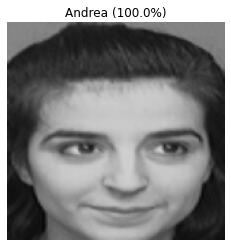

Predicted: Oliver
Expected: Oliver


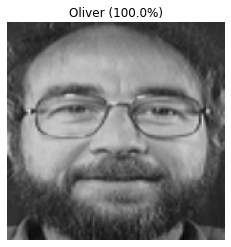

Predicted: Junwei
Expected: Junwei


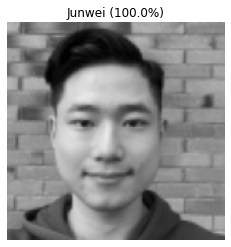

Predicted: Junwei
Expected: Junwei


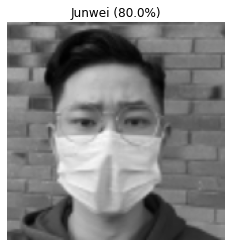

Predicted: Peter
Expected: Peter


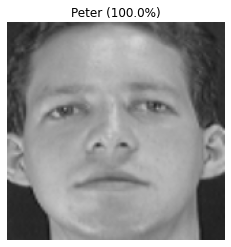

Predicted: Kechen
Expected: Kechen


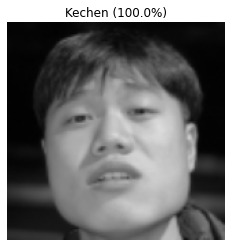

Predicted: Chenhong
Expected: Chenhong


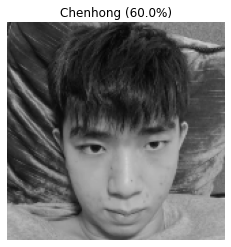

Predicted: Ramli
Expected: Ramli


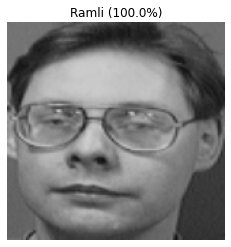

Predicted: Chenhong
Expected: Chenhong


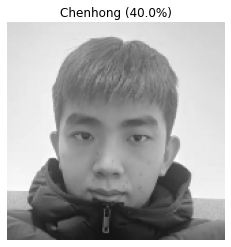

Predicted: Yichang
Expected: Yichang


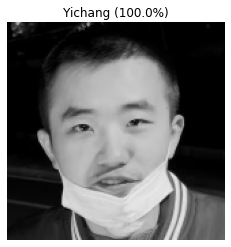

Predicted: Adrian
Expected: Adrian


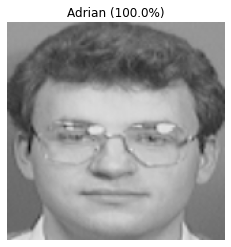

Predicted: Yichang
Expected: Yichang


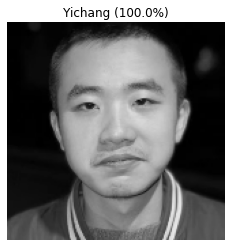

Predicted: Hanting
Expected: Hanting


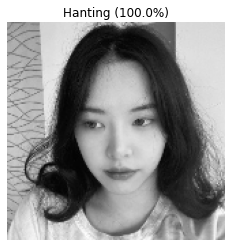

Predicted: Hanting
Expected: Hanting


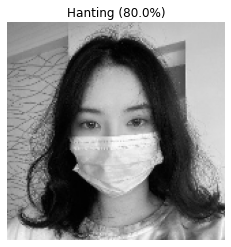

Predicted: Maxus
Expected: Maxus


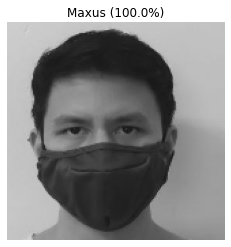

In [ ]:
for i in range(X_test.shape[0]):
  face_pixels = X_test[i]
  face_embeddings = X_test_transformed[i]
  face_class = y_test[i]
  face_name = out_encoder.inverse_transform([face_class])
  # expand the dimensions into a tensor 
  samples = expand_dims(face_embeddings, axis=0)
  # predicted y from KNN
  yhat_class = knn.predict(samples)[0]
  yhat_prob = knn.predict(samples)[1]
  class_index = yhat_class[0]
  # class_probability = yhat_prob
  predict_names = out_encoder.inverse_transform(yhat_class)
  print('Predicted: %s' % (predict_names[0]))
  print(f'Expected: {face_name[0]}')
  plt.imshow(face_pixels)
  plt.axis('off')
  title = f'{predict_names[0]} ({yhat_prob[0] * 100}%)'
  plt.title(title)
  plt.show()

# Appendix

## **Reference:**
Dosovitskiy, A., Beyer, L., Kolesnikov, A., Weissenborn, D., Zhai, X., Unterthiner, T., Dehghani, M., Minderer, M., Heigold, G., Gelly, S., Uszkoreit, J. & Houlsby, N. (2020). An image is worth 16x16 words: Transformers for image recognition at scale. arXiv preprint arXiv:2010.11929.

Forsythe, M. M. (2021, September 21). Generate image embeddings using a pre-trained CNN and store them in Hub. Activeloop. Retrieved February 28, 2022, from https://www.activeloop.ai/resources/1E3oKP83o4KXIFChCesv7r/generate-image-embeddings-using-a-pre-trained-cnn-and-store-them-in-hub/ 

Image filtering using convolution in opencv. LearnOpenCV. (2021, July 15). Retrieved February 28, 2022, from https://learnopencv.com/image-filtering-using-convolution-in-opencv/ 

Le, K. D. (2019). A Study of Face Embedding in Face Recognition.

Lee, W. M. (2022, January 31). Using principal component analysis (PCA) for Machine Learning. Medium. Retrieved February 28, 2022, from https://towardsdatascience.com/using-principal-component-analysis-pca-for-machine-learning-b6e803f5bf1e 

Najafabadi, M. M., Villanustre, F., Khoshgoftaar, T. M., Seliya, N., Wald, R., & Muharemagic, E. (2015). Deep learning applications and challenges in big data analytics. Journal of big data, 2(1), 1-21.
Seguin, J. (2017, October 30). Overfitting and regularization. IRIC's Bioinformatics Platform. Retrieved February 28, 2022, from https://bioinfo.iric.ca/overfitting-and-regularization/ 

Shanthamallu, U. S., & Spanias, A. (2021). Machine and Deep Learning Algorithms and Applications. Synthesis Lectures on Signal Processing, 12(3), 1-123.

Turk, M. A., & Pentland, A. P. (1991, January). Face recognition using eigenfaces. In Proceedings. 1991 IEEE computer society conference on computer vision and pattern recognition (pp. 586-587). IEEE Computer Society.

Valueva, M. V., Nagornov, N. N., Lyakhov, P. A., Valuev, G. V., & Chervyakov, N. I. (2020). Application of the residue number system to reduce hardware costs of the convolutional neural network implementation. Mathematics and Computers in Simulation, 177, 232-243.

Wang, H. (2022, March 4). Face Recognition (G0191 Chapter 1) [PowerPoint Slides]. Xiamen University Malaysia.

Wang, H. (2022, March 4). Real-Time Face Detection (G0191 Chapter 2) [PowerPoint Slides]. Xiamen University Malaysia.

Wang, H. (2022, March 4). Classifiers (G0191 Chapter 3 & 4) [PowerPoint Slides]. Xiamen University Malaysia.

Wall, M. E., Rechtsteiner, A., & Rocha, L. M. (2003). Singular value decomposition and principal component analysis. In A practical approach to microarray data analysis (pp. 91-109). Springer, Boston, MA.